In [1]:
!pip install geopandas
!pip install mapclassify
!pip install rasterio

     |████████████████████████████████| 1.0 MB 20.9 MB/s 
     |████████████████████████████████| 16.7 MB 57.0 MB/s 
     |████████████████████████████████| 6.3 MB 9.4 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [2]:
# not all used at the moment but might be used later
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gp
import folium
import geopandas
import mapclassify
import zipfile
import requests
import xml.etree.ElementTree as ET
import rasterio
from rasterio.plot import show
from tqdm import tqdm

!mkdir fip_tif

In [3]:
# this mounts your google drive 
from google.colab import drive
drive.mount('/content/gdrive')

# this saves the downloaded images to your google drive
!mkdir '/content/gdrive/My Drive/fip_tif'

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/fip_tif’: File exists


^C


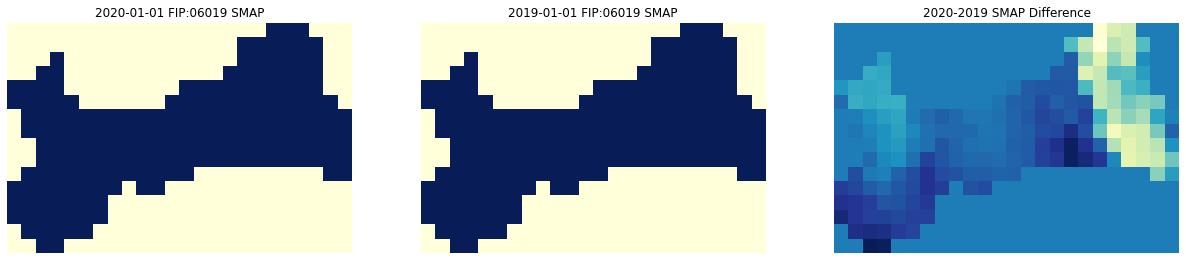

In [4]:
# get weekly average SMAP by FIP
# some examples outputted below, demonstrates speed depending on how fast this loads 2 images
def get_SMAP_image(date, fip):
    fip = fip
    date = date
    date_str = datetime.datetime.strptime(date, '%Y.%m.%d').date().strftime('%Y-%m-%d')

    url = f'https://cloud.csiss.gmu.edu/smap_service?service=WPS&version=1.0.0&request=Execute&identifier=GetFileByFips&DataInputs=layer=SMAP-9KM-DAILY-SUB_{date}_AVERAGE;fips={fip}'

    r = requests.get(url)

    response_xml_as_string = r.text
    responseXml = ET.fromstring(response_xml_as_string)

    tif_url = responseXml[2][0][3][0].text
    
    !wget $tif_url -O $'/content/gdrive/My Drive/fip_tif/{fip}_{date_str}.tif' -q --no-check-certificate
    # !cp 'fip_tif/06019_2019-01-01.tif' '/content/gdrive/My Drive/fip_tif/06019_2019-01-01.tif'


    return rasterio.open(f'/content/gdrive/My Drive/fip_tif/{fip}_{date_str}.tif').read()

im1 = get_SMAP_image('2020.01.01', '06019')
im2 = get_SMAP_image('2019.01.01', '06019')
dif = im1 - im2

fig, ax = plt.subplots(1,3, figsize=(21,7))

show(dif, ax=ax[2], cmap = 'YlGnBu')

show(im2, ax=ax[1],cmap = 'YlGnBu')
show(im1, ax=ax[0],cmap = 'YlGnBu')

ax[0].set_title('2020-01-01 FIP:06019 SMAP')
ax[1].set_title('2019-01-01 FIP:06019 SMAP')
ax[2].set_title('2020-2019 SMAP Difference')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.show()




In [6]:
# skip is the last county already downloaded
num_weeks = 376
skip = 67
base = datetime.date.fromisoformat('2022-02-22')
date_list = [base - datetime.timedelta(weeks=(x)) for x in range(num_weeks)]

# add 0-padding to county FIPS
county_list = pd.read_csv('County_450.csv')['county'].astype(str)[skip:]
county_list = [x.zfill(5) for x in county_list]

# Number of counties left in list
print(len(county_list),'counties left')

383 counties left


In [ ]:
#  This function downloads images and saves their averages to CSVs, a new CSV is made every county
#  to ensure this process can fail and steps along the way can be saved
data_by_FIP = pd.DataFrame()
data_by_FIP['Dates'] = date_list
temp_data = []

for j, county in enumerate(county_list):
    for i in tqdm(range(num_weeks)):
        try:
            im = get_SMAP_image(date_list[i].strftime('%Y.%m.%d'), county)
            temp_data.append(im[im > -9999].mean())
        except:
            temp_data.append(-9999)
            continue
    data_by_FIP[county] = temp_data
    data_by_FIP.to_csv(f'smap_test_avgs_{j+skip}_counties.csv')
    temp_data = []


 23%|██▎       | 88/376 [06:11<25:49,  5.38s/it]

In [ ]:
# This function finds avereages from already downloaded and saved images

path =  '/content/gdrive/My Drive/fip_tif'
data_by_FIP = pd.DataFrame()
temp_data = []

for county in county_list:
    for date in tqdm(date_list):
        date_str = date.strftime('%Y-%m-%d')
        filename = (path + f'{county}_{date_str}.tif')
        try:
            im = rasterio.open(filename).read()
            temp_data.append(im[im > -9999].mean())
        except:
            temp_data.append(-9999)
            continue            
    data_by_FIP[county] = temp_data
    temp_data = []

# date_str = date_list[10].strftime('%Y-%m-%d')
# path + f'{county}_{date_str}.tif'

# x = rasterio.open(path + f'{county}_{date_str}.tif').read()


100%|██████████| 531/531 [00:51<00:00, 10.26it/s]


In [ ]:
data_by_FIP.to_csv('smap_test_avgs.csv')


In [ ]:
# # This function does not get average of images JUST the URL of the image, to remonstrate how slow even this process is

# def get_SMAP_image_url(date, fip):
#     fip = fip
#     date = date
#     date_str = datetime.datetime.strptime(date, '%Y.%m.%d').date().strftime('%Y-%m-%d')

#     url = f'https://cloud.csiss.gmu.edu/smap_service?service=WPS&version=1.0.0&request=Execute&identifier=GetFileByFips&DataInputs=layer=SMAP-9KM-DAILY-SUB_{date}_AVERAGE;fips={fip}'

#     r = requests.get(url)

#     response_xml_as_string = r.text
#     responseXml = ET.fromstring(response_xml_as_string)

#     tif_url = responseXml[2][0][3][0].text
    
#     return tif_url

# data_by_FIP = pd.DataFrame()
# data_by_FIP['Dates'] = date_list
# temp_data = []

# for j, county in enumerate(county_list):
#     for i in tqdm(range(num_weeks)):
#         try:
#             url = get_SMAP_image_url(date_list[i].strftime('%Y.%m.%d'), county)
#             temp_data.append(url)
#         except:
#             temp_data.append('URL not found')
#             continue
#     data_by_FIP[county] = temp_data
#     temp_data = []

# data_by_FIP


100%|█████████▉| 375/376 [02:16<00:00,  2.76it/s]

In [ ]:
df = pd.read_csv('smap_test_avgs_68_counties.csv')
df = df.drop(df.columns[[0, -7, -6, -9, -10, -18, -19, 21, 22, -5]], axis = 1)
df = df.drop('06093.1', axis = 1)

df.shape
df.to_csv('smap_merged_65_counties.csv')